In [1]:
import torch
from torch.autograd import Variable
from torchvision import models
import numpy as np
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import dataset
from finetune import PrunningFineTuner
from ModifiedAlexNet import ModifiedAlexNet
import time
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
dataset_dir = "../Cat_Dog_data/"
train_path = dataset_dir+"train"
test_path = dataset_dir+"test"

In [4]:
train_data_loader = dataset.loader(train_path, size = 256)
test_data_loader = dataset.test_loader(test_path, size = 256)

In [14]:
alexnet = ModifiedAlexNet().to(device)
alexnet.eval()

ModifiedAlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias

In [15]:
epoches = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(alexnet.classifier.parameters(), lr=0.0001, momentum=0.9)

In [16]:
def train(model, optimizer, epoches, train_data_loader,test_data_loader, device):
    
    for i in range(epoches):
        print("Epoch: ", i, end="  ")
        for i, (batch, label) in enumerate(train_data_loader):
            
            batch = batch.to(device)
            label = label.to(device)
            model.zero_grad()
            batch = Variable(batch)
            criterion(model(batch), Variable(label)).backward()
            optimizer.step()

        test(model, test_data_loader, device)

In [17]:
def test(model, test_data_loader, device):
    correct = 0
    total = 0
    for i, (batch, label) in enumerate(test_data_loader):
        batch = batch.to(device)
        output = model(Variable(batch))
        pred = output.data.max(1)[1]
        correct += pred.cpu().eq(label).sum()
        total += label.size(0)

    print("Accuracy :", float(correct) / total)

In [18]:
#Initial accuracy 
test(alexnet, test_data_loader, device)

#train fine tuned model
import time
start = time.time()
train(alexnet, optimizer, epoches, train_data_loader, test_data_loader, device)
end = time.time()
print("training time: ",end - start, " secs.")

Accuracy : 0.5084
Epoch:  0  Accuracy : 0.9436
Epoch:  1  Accuracy : 0.9524
Epoch:  2  Accuracy : 0.9568
Epoch:  3  Accuracy : 0.9576
Epoch:  4  Accuracy : 0.9596
training time:  550.8544845581055  secs.


In [20]:
torch.save(alexnet, "alexnet")

In [21]:
total_params = sum(p.numel() for p in alexnet.parameters())
print("Numbre of parameters:", total_params)

Numbre of parameters: 57012034


In [22]:
alexnet = torch.load("alexnet")

In [23]:
fine_tuner_alexnet = PrunningFineTuner(train_path, test_path, alexnet, device, size = 256)

In [24]:
def prune(model):
    hist = {"parameters":[], "accuracy":[], "filters":[], "accuracy_retrained_model":[]}
    
    hist["parameters"].append(model.get_number_of_parameters())
    hist["accuracy"].append(model.test())
    hist["filters"].append(model.total_num_filters())
    hist["accuracy_retrained_model"].append(model.test())
    
    number_of_filters = model.total_num_filters()
    filter_per_iteration = int(number_of_filters*0.2)
    
    for i in range(4):
        print("-------------------------------")
        acc = model.prune(filter_per_iteration)
        if(i%2 == 1):
            torch.save(model, "alexnet_prunned"+str(i))
        hist["parameters"].append(model.get_number_of_parameters())
        hist["accuracy"].append(acc)
        hist["filters"].append(model.total_num_filters())
        hist["accuracy_retrained_model"].append(model.test())
    return hist

In [25]:
#prune the filters in the model
hist = prune(fine_tuner_alexnet)

-------------------------------
Accuracy before pruning: 0.9596
Number of filters to prune 230
Ranking filters.. 
Layers that will be prunned {10: 62, 6: 89, 3: 21, 8: 52, 0: 6}
Prunning filters.. 
Filters prunned 19.96527777777778%
Fine tuning to recover from prunning iteration.
Epoch:  0
Accuracy : 0.9548
Epoch:  1
Accuracy : 0.9624
Epoch:  2
Accuracy : 0.96
Epoch:  3
Accuracy : 0.9488
Epoch:  4
Accuracy : 0.964
Finished fine tuning.
-------------------------------
Accuracy before pruning: 0.964
Number of filters to prune 230
Ranking filters.. 
Layers that will be prunned {10: 54, 8: 55, 6: 86, 3: 31, 0: 4}
Prunning filters.. 
Filters prunned 24.945770065075923%
Fine tuning to recover from prunning iteration.
Epoch:  0
Accuracy : 0.9484
Epoch:  1
Accuracy : 0.9384
Epoch:  2
Accuracy : 0.9568
Epoch:  3
Accuracy : 0.9604
Epoch:  4
Accuracy : 0.9628
Finished fine tuning.


/home/cisd-greigra/anaconda/envs/pruning/lib/python3.8/site-packages/torch/utils/hooks.py:57: UserWarning: backward hook <bound method FilterPrunner.compute_rank of <finetune.FilterPrunner object at 0x7fd232baa1c0>> on tensor will not be serialized.  If this is expected, you can decorate the function with @torch.utils.hooks.unserializable_hook to suppress this warning
  warnings.warn("backward hook {} on tensor will not be "


-------------------------------
Accuracy before pruning: 0.9628
Number of filters to prune 230
Ranking filters.. 
Layers that will be prunned {6: 81, 10: 53, 8: 50, 3: 40, 0: 6}
Prunning filters.. 
Filters prunned 33.23699421965318%
Fine tuning to recover from prunning iteration.
Epoch:  0
Accuracy : 0.9332
Epoch:  1
Accuracy : 0.9508
Epoch:  2
Accuracy : 0.9488
Epoch:  3
Accuracy : 0.95
Epoch:  4
Accuracy : 0.9552
Finished fine tuning.
-------------------------------
Accuracy before pruning: 0.9552
Number of filters to prune 230
Ranking filters.. 
Layers that will be prunned {6: 68, 10: 40, 0: 21, 3: 47, 8: 54}
Prunning filters.. 
Filters prunned 49.78354978354978%
Fine tuning to recover from prunning iteration.
Epoch:  0
Accuracy : 0.9148
Epoch:  1
Accuracy : 0.9208
Epoch:  2
Accuracy : 0.9252
Epoch:  3
Accuracy : 0.926
Epoch:  4
Accuracy : 0.9024
Finished fine tuning.


In [26]:
print(hist[""])

{'parameters': [57012034, 47021801, 38378085, 30066925, 23841797], 'accuracy': [0.9596, 0.9332, 0.9284, 0.912, 0.5728], 'filters': [1152, 922, 692, 462, 232], 'accuracy_retrained_model': [0.9596, 0.964, 0.9628, 0.9552, 0.9024]}


(1152.0, 232.0)

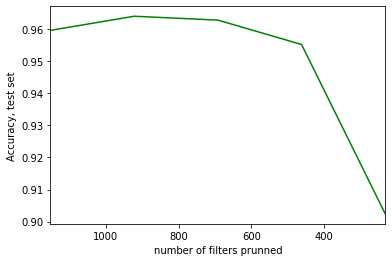

In [32]:
import matplotlib.pyplot as plt
plt.plot(hist["filters"], hist["accuracy_retrained_model"], color='green')
plt.xlabel('number of filters not prunned')
plt.ylabel('Accuracy, test set')
plt.xlim(hist["filters"][0], hist["filters"][-1])
#plt.title("")
#plt.legend()
#plt.savefig('prunningfilters.png')


In [ ]:
plt.plot(hist["filters"], hist["accuracy_retrained_model"], color='green')
plt.xlabel('number of filters not prunned')
plt.ylabel('Accuracy, test set')
plt.xlim(hist["filters"][0], hist["filters"][-1])
